In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import *

In [2]:
train = pd.read_csv(r"yelp_train.csv")
test = pd.read_csv(r"yelp_test.csv")

Xtest = test.drop("stars", axis = 1)
Ytest = test["stars"]
Xtrain = train.drop("stars", axis = 1)
Ytrain = train["stars"]


In [3]:
### Regression model using all available independent variables.
model = smf.ols('stars ~ review_count + C(GoodForKids, Treatment(reference="(Missing)")) + C(Alcohol, Treatment(reference="(Missing)")) \
                + C(BusinessAcceptsCreditCards, Treatment(reference="(Missing)")) + C(WiFi, Treatment(reference="(Missing)"))\
                + C(BikeParking, Treatment(reference="(Missing)")) + C(ByAppointmentOnly, Treatment(reference="(Missing)"))\
                + C(WheelechairAccessible, Treatment(reference="(Missing)")) + C(OutdoorSeating, Treatment(reference="(Missing)"))\
                + C(RestaurantsReservations, Treatment(reference="(Missing)")) + C(DogsAllowed, Treatment(reference="(Missing)"))\
                + C(Caters, Treatment(reference="(Missing)"))', data = train).fit()

In [4]:
#ols predictions, storing for later.
r2d2 = model.predict(Xtest)

In [5]:
#dummy encode the X training matrix.
Dummy_train = pd.get_dummies(Xtrain, columns = [col for col in Xtrain.columns if col != "review_count"], drop_first = True)


In [6]:
#grid of candidates, 10 folds for each of 675 different models. 

grid_values = {'ccp_alpha': np.linspace(0,0.01, 20),
               'min_samples_leaf': [4,5,6],
               'min_samples_split': [20,25,30],
               'max_depth': [ 5,10,15,20],
               }

# Find and fit the good model            
dtr = DecisionTreeRegressor()
dtc_cv_acc = GridSearchCV(dtr, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=5)
dtc_cv_acc.fit(Dummy_train, Ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': array([0.        , 0.00052632, 0.00105263, 0.00157895, 0.00210526,
       0.00263158, 0.00315789, 0.00368421, 0.00421053, 0.00473684,
       0.00526316, 0.00578947, 0.00631579, 0.00684211, 0.00736842,
       0.00789474, 0.00842105, 0.00894737, 0.00947368, 0.01      ]),
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [20, 25, 30]},
             scoring='neg_mean_squared_error')

In [7]:
# checked the best parameters for the tree manually. did not do this for the next tree.
print(dtc_cv_acc.best_params_)

{'ccp_alpha': 0.0010526315789473684, 'max_depth': 15, 'min_samples_leaf': 6, 'min_samples_split': 30}


Node count = 51


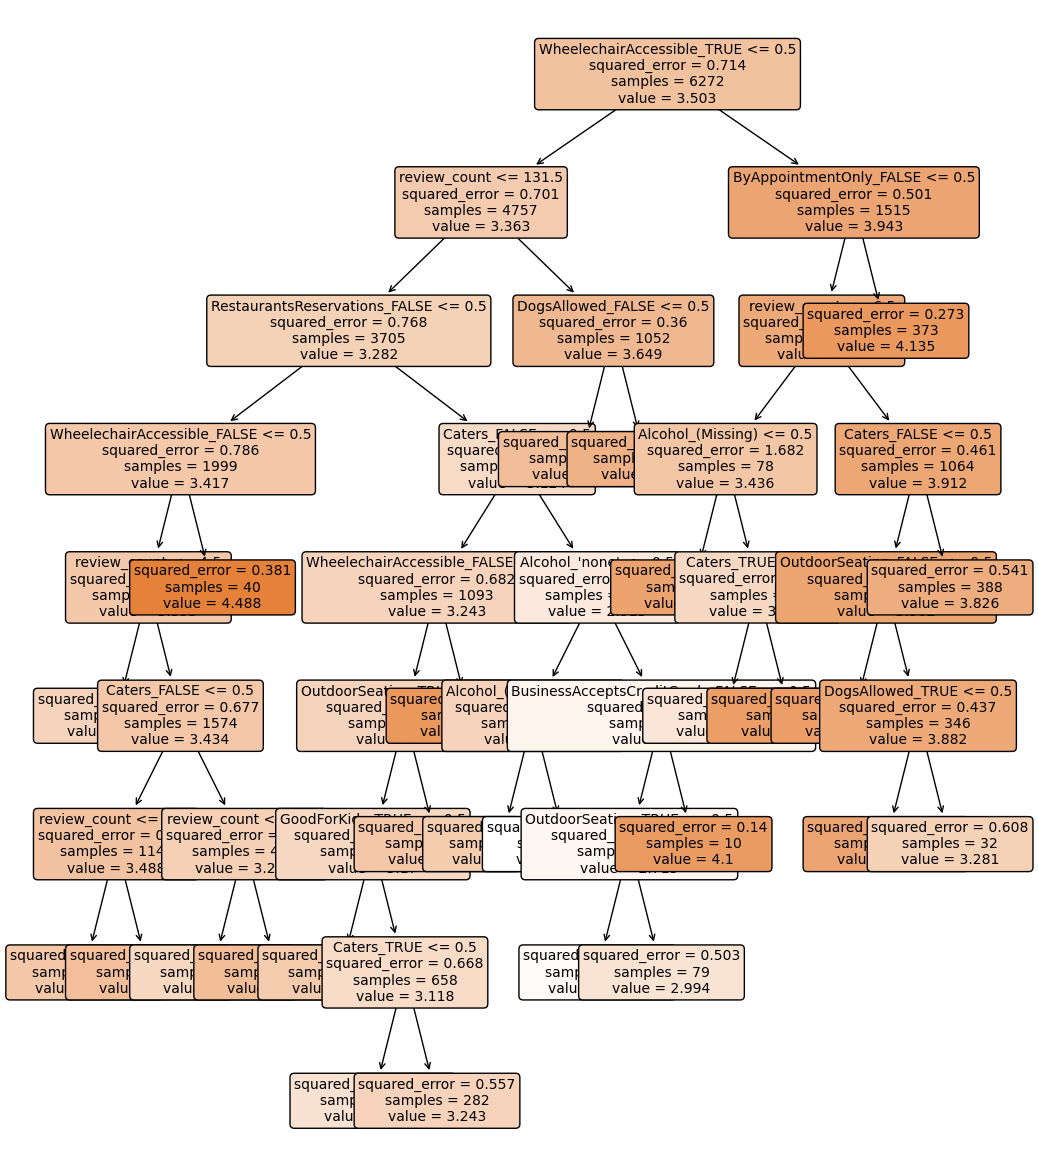

In [8]:
#setting my decision tree parameters to the candidates found by grid search.
dtrBest =  DecisionTreeRegressor(min_samples_leaf=6,
                                 ccp_alpha=0.0010526315789473684,
                                 max_depth = 15,
                                 min_samples_split = 25)
tree = dtrBest.fit(Dummy_train,Ytrain)

#Tree diagram plot

print('Node count =', dtrBest.tree_.node_count)
plt.figure(figsize=(12,15))
plot_tree(dtrBest,
          feature_names = Dummy_train.columns,
          filled=True,
          impurity=True,
          rounded=True,
          fontsize = 10
          )
plt.show()


In [9]:
#encoding my Test set, and predicting target variables.
DummyTest = pd.get_dummies(Xtest, columns = [col for col in Xtest.columns if col != "review_count"], drop_first = True)

Ypred = tree.predict(DummyTest)


In [10]:
#functions for OSR^2 and MAE
def OSR2(Ypreds, trueTest):
    RSS = np.sum((trueTest - Ypreds)**2 )
    TSS = np.sum((trueTest - np.mean(trueTest))**2)
    return 1 - (RSS/TSS)
def MAE(Ypreds, trueTest):
    return np.sum(np.abs(Ypreds - trueTest))/len(Ypreds)
    

In [11]:
#the following cells are outputs of OSR2 and MAE of decision tree and regression predictions. 

MAE(Ypred, Ytest)

0.6252132561993073

In [12]:
OSR2(Ypred, Ytest)

0.15099276886806745

In [13]:
regrPred = model.predict(Xtest)

In [14]:
MAE(regrPred, Ytest)

0.630129081526346

In [15]:
OSR2(regrPred, Ytest)

0.1625081247047695

In [16]:
#make copies so we can establish a new target variable,boolean of above/ below 4 star rating.
trainGT4, testGT4 = train.copy(), test.copy()


In [17]:
#make bool columns if a row has a rating of >= 4
trainGT4["fourOrAbove"] = (trainGT4["stars"] >= 4).astype(int)
testGT4["fourOrAbove"] = (testGT4["stars"] >=4).astype(int)

In [18]:
#2d ii:
# Code for converting predictions of at least four/ below 4 into boolean outcomes

def regr4orAbove(x):
    x = np.asarray(x)
    return [1 if i >= 4 else 0 for i in x ]

def logitYhat(x):
    x = np.asarray(x)
    return [1 if i>= 0.35272055398 else 0 for i in x]

In [19]:
#logistic regression model for Four or above rating classifier

logistic4OA = smf.logit('fourOrAbove ~ review_count + C(GoodForKids, Treatment(reference="(Missing)")) + C(Alcohol, Treatment(reference="(Missing)")) \
                + C(BusinessAcceptsCreditCards, Treatment(reference="(Missing)")) + C(WiFi, Treatment(reference="(Missing)"))\
                + C(BikeParking, Treatment(reference="(Missing)")) + C(ByAppointmentOnly, Treatment(reference="(Missing)"))\
                + C(WheelechairAccessible, Treatment(reference="(Missing)")) + C(OutdoorSeating, Treatment(reference="(Missing)"))\
                + C(RestaurantsReservations, Treatment(reference="(Missing)")) + C(DogsAllowed, Treatment(reference="(Missing)"))\
                + C(Caters, Treatment(reference="(Missing)"))', data = trainGT4).fit()

Optimization terminated successfully.
         Current function value: 0.607102
         Iterations 6


In [20]:
#predictions of the logistic regression function.
logitPred = logistic4OA.predict(Xtest)
logitPred = 1/(1+ np.e**logitPred)
logitPred

0       0.414209
1       0.317227
2       0.308660
3       0.354872
4       0.422787
          ...   
2683    0.396007
2684    0.437190
2685    0.319350
2686    0.329078
2687    0.376931
Length: 2688, dtype: float64

In [21]:
#dataframe cleaning, etc.
trainGT4X = trainGT4.drop(columns = ["stars","fourOrAbove"])
testGT4X = testGT4.drop(columns = ["stars","fourOrAbove"])
testGT4X = pd.get_dummies(testGT4X, columns = [col for col in Xtest.columns if col != "review_count"], drop_first = True)
testGT4Y = testGT4["fourOrAbove"]
trainGT4Y = trainGT4["fourOrAbove"]
trainGT4X = pd.get_dummies(trainGT4X, columns = [col for col in Xtest.columns if col!= "review_count"], drop_first = True)


In [22]:
#Cross validation and model fitting for classification tree
grid_values = {'ccp_alpha': np.linspace(0,0.01,26),
               'min_samples_leaf': [3,4,5,6,7],
               'min_samples_split': [15,20,25],
               'max_depth': np.arange(12,20),
               'class_weight' : ["balanced"],
               }

            
dtc = DecisionTreeClassifier()
dtcCV = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=4, verbose=1,n_jobs = -1) # default scoring metric to optimize is accuracy, used as default if none given.
dtcCV.fit(trainGT4X, trainGT4Y)

Fitting 4 folds for each of 3120 candidates, totalling 12480 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
       0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
       0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
       0.0096, 0.01  ]),
                         'class_weight': ['balanced'],
                         'max_depth': array([12, 13, 14, 15, 16, 17, 18, 19]),
                         'min_samples_leaf': [3, 4, 5, 6, 7],
                         'min_samples_split': [15, 20, 25]},
             scoring='accuracy', verbose=1)

{'ccp_alpha': 0.0008, 'class_weight': 'balanced', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 15}
Node count = 45


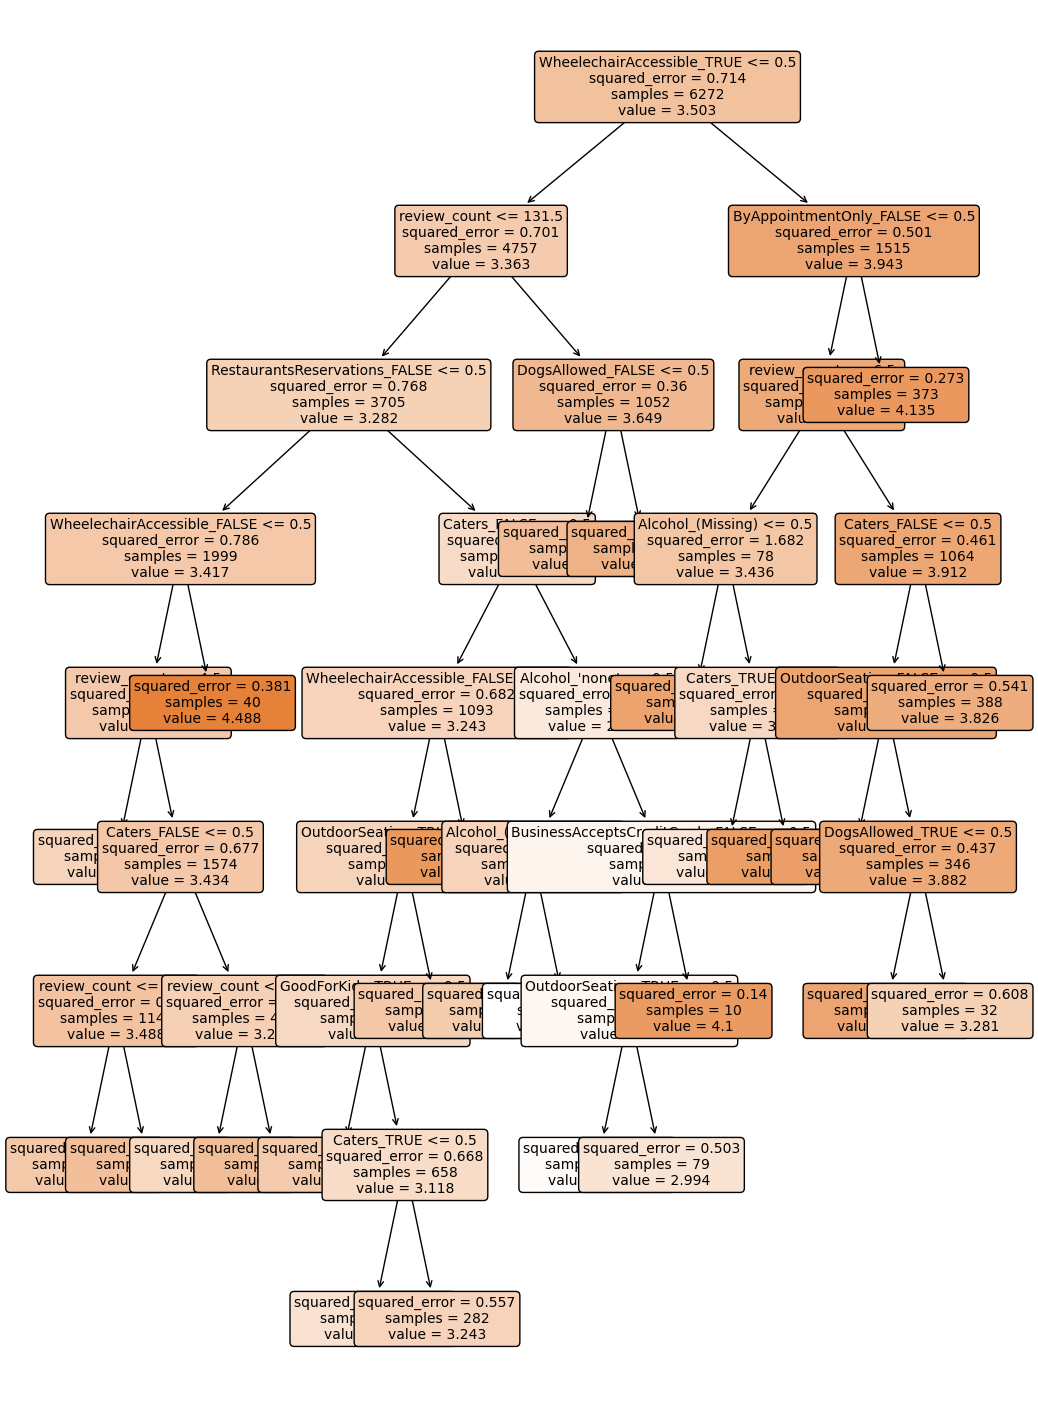

In [23]:
#tree diagram for classifier
print(dtcCV.best_params_)
print('Node count =', dtcCV.best_estimator_.tree_.node_count)
plt.figure(figsize=(12,18))
plot_tree(dtrBest,
          feature_names = trainGT4X.columns,
          filled=True,
          impurity=True,
          rounded=True,
          fontsize = 10
          )
plt.show()

In [24]:
#grid search's best parameters for my model given the candidates in the cross validation.
dtcCV.best_params_

{'ccp_alpha': 0.0008,
 'class_weight': 'balanced',
 'max_depth': 12,
 'min_samples_leaf': 3,
 'min_samples_split': 15}

In [25]:
#predict the Above 4 star rating for each estabishment using the classfication tree.
Ypred2 = dtcCV.best_estimator_.predict(testGT4X)
Ypred2

array([0, 1, 1, ..., 1, 1, 1])

In [26]:
#baseline naive classifier, predicts mode of the outcomes.
y_baseline = testGT4Y.mode()
modePred = pd.Series([y_baseline[0] for _ in range(len(testGT4Y))])


In [27]:
#function that returns a 3-list with accuracy, TPR, and FPR given a true y values array and a predicted array.
def AccTFR(y,yhat):
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    return [np.mean(y == yhat), np.sum((y == 1) & (yhat == 1)) / (np.sum((y == 1) & (yhat == 1)) + np.sum((y == 1) & (yhat == 0))), np.sum((y==0) & (yhat == 1)) / (np.sum((y==0) & (yhat == 1)) + np.sum((y == 0) & (yhat == 0)))]

In [28]:
# constructing the dataframe "table" for each of the five models, with accuracy, tpr, and fpr being displayed for each 

df = pd.DataFrame()

df["baseline"] = AccTFR(testGT4Y,modePred)
df["lin. regression Threshold"] = AccTFR(testGT4Y, regr4orAbove(r2d2))
df["regressor Dec. Tree"] = AccTFR(testGT4Y, regr4orAbove(Ypred))
df["log. Regression"] = AccTFR(testGT4Y, logitYhat(logitPred))
df["Classification Tree"] = AccTFR(testGT4Y, Ypred2)

df.index = ["Accuracy:", "TPR:","FPR:"]
df

,baseline,lin. regression Threshold,regressor Dec. Tree,log. Regression,Classification Tree
Accuracy:,0.551339,0.616071,0.616443,0.338542,0.643229
TPR:,0.000000,0.203980,0.202322,0.628524,0.538143
FPR:,0.000000,0.048583,0.046559,0.897436,0.271255


In [29]:
#question 2e- feature importance
imp = dtcCV.best_estimator_.feature_importances_
features = Dummy_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': imp
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
16,WheelechairAccessible_TRUE,0.488146
0,review_count,0.195819
15,WheelechairAccessible_FALSE,0.068601
19,RestaurantsReservations_FALSE,0.065059
23,Caters_FALSE,0.052794
3,Alcohol_'full_bar',0.024468
13,ByAppointmentOnly_FALSE,0.022670
18,OutdoorSeating_TRUE,0.022189
6,BusinessAcceptsCreditCards_FALSE,0.021529
21,DogsAllowed_FALSE,0.014867
